EAR բանաձևը հաշվում է աչքի բացվածության հարաբերակցությունը։
A, B – ուղղահայաց հեռավորություններ աչքի կետերի միջև։
C – հորիզոնական հեռավորություն։
Արդյունքում՝ (A + B) / (2 * C) վերադարձնում է EAR արժեքը։


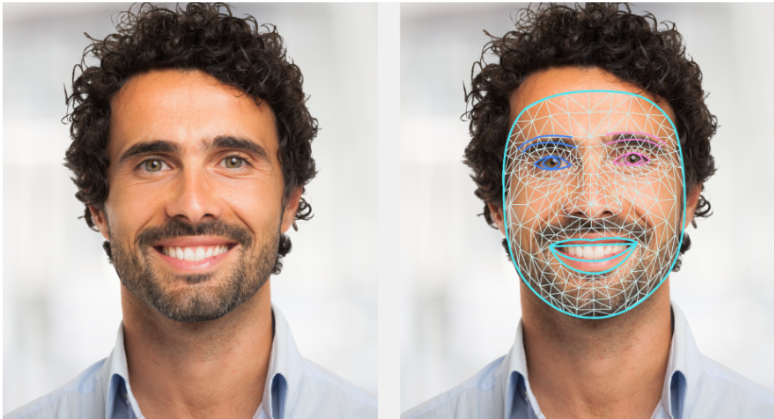

#### EAR_THRESHOLD = 0.21
Գիտական հիմք
Soukupová & Čech (2016) հետազոտության համաձայն, EAR շեմը սովորաբար 0.15-0.25 միջակայքում է:

Կարգավորում

0.21-ը ընտրվել է հավասարակշռելու զգայունությունն ու կեղծ դրականները:

< 0.2 → շատ զգայուն (կարող է հայտնաբերել նույնիսկ կարճ թարթումները):

0.25 → քիչ զգայուն (կարող է բաց թողնել մասնակի փակված աչքեր):



#### CONSEC_FRAMES = 10
##### Տրամաբանություն

30 FPS տեսախցիկի դեպքում 10 շրջանակ = ~0.33 վայրկյան:

Բավարար է քնի սկիզբը հայտնաբերելու, բայց կարճ է նորմալ թարթումների համար:

Փորձնականորեն պարզվել է, որ 10 շրջանակը հնարավորություն է տալիս խուսափել կեղծ ազդանշաններից:



#### MOUTH_INDICES = [13, 14, 78, 308]
MediaPipe-ում այս կետերը համապատասխանում են բերանի վերին, ներքևի, ձախ և աջ ծայրերին:

13: վերին շրթունքի կենտրոն

14: ներքևի շրթունքի կենտրոն

78 և 308: բերանի անկյուններ

Այս 4 կետերը օպտիմալ են բերանի բացվածքը հաշվարկելու համար:

#### MAR_THRESHOLD = 0.85
##### Տրամաբանություն 

MAR = ուղղահայաց / հորիզոնական հեռավորություն:

Ուղղահայացը մեծ է հորիզոնականից → MAR > 1:

0.85 շեմը ընտրվել է, որպեսզի.

Բաց բերանը (MAR ≈ 1.0-1.5) ակտիվացնի ազդանշան:

Նորմալ խոսելը (MAR ≈ 0.5-0.7) անտեսվի

#### YAWN_CONSEC_FRAMES = 20
Ձագանքը ավելի դանդաղ գործողություն է, քան աչքերի փակումը:

20 շրջանակ = ~0.66 վայրկյան (30 FPS-ում):

Սա կանխում է կեղծ դրականները՝ կապված ժպիտների կամ խոսելու հետ:

#### warmup_frames = 30
Տեսախցիկին անհրաժեշտ է ~1 վայրկյան (30 շրջանակ 30 FPS-ում) կայունանալու համար:

Առաջին շրջանակները հաճախ լինում են մութ կամ աղավաղված (ավտոֆոկուսի, լուսավորության կարգավորման պատճառով):

In [1]:
# Գրադարանների ներմուծում
import cv2 
import numpy as np  # թվային գործողությունների համար
from ultralytics import YOLO # YOLO մոդել դեմքի հայտնաբերման համար
import mediapipe as mp  # դեմքի լանդմարքների հայտնաբերման համար
from pygame import mixer   # ձայնային ազդանշանի համար
import time   # ժամանակի հաշվարկի համար

# Ալարմի սկզբնավորում
mixer.init() # ձայնային համակարգի սկզբնավորում
alarm_path = r"C:\Users\adont\OneDrive\Desktop\RealTimeDrowsyDrivingDetection-main\utils\alarm.WAV"
mixer.music.load(alarm_path)  # ձայնային ֆայլի բեռնում
ALARM_COOLDOWN = 5  # ալարման միջև հանգստի ժամանակ (վայրկյան)
last_alarm_time = 0

# Մոդելների սկզբնավորում
face_model = YOLO(r"C:\Users\adont\OneDrive\Desktop\RealTimeDrowsyDrivingDetection-main\models\yolov8-face\yolov8n-face.pt")  # YOLOv8 դեմքի դետեկտոր
mp_face_mesh = mp.solutions.face_mesh  # Mediapipe-ի դեմքի ցանց
face_mesh = mp_face_mesh.FaceMesh(  
    max_num_faces=1,   # միաժամանակ մեկ դեմք
    refine_landmarks=True,  # ճշգրիտ լանդմարքներ
    min_detection_confidence=0.7, # նվազագույն վստահություն
    min_tracking_confidence=0.7)

#  Աչքի EAR պարամետրեր (Eye Aspect Ratio)
LEFT_EYE_INDICES = [362, 385, 387, 263, 373, 380]  # ձախ աչքի լանդմարքներ
RIGHT_EYE_INDICES = [33, 160, 158, 133, 153, 144]   # աջ աչքի լանդմարքներ
EAR_THRESHOLD = 0.21  # շեմային արժեք՝ աչքերի փակումը որոշելու համար
CONSEC_FRAMES = 10     # շարունակական շրջանակների քանակ ալարման համար
COUNTER = 0

# Բերանի MAR պարամետրեր (Mouth Aspect Ratio)
MOUTH_INDICES = [13, 14, 78, 308]  # բերանի լանդմարքներ [վերև, ներքև, ձախ, աջ]
MAR_THRESHOLD = 0.85  # Increased threshold to prevent false positives
YAWN_CONSEC_FRAMES = 20  # Require longer yawn duration
yawn_counter = 0

# Արտադրողականության օպտիմիզացիա (Optimization)
FRAME_SKIP = 1  # յուրաքանչյուր շրջանակի մշակում
warmup_frames = 30 # տաքացման փուլ (կամերայի կարգավորում)
frame_counter = 0  # շրջանակների հաշվիչ

# EAR հաշվարկի ֆունկցիա
def eye_aspect_ratio(eye_points):
    """Calculate EAR using 6 points per eye."""    # Հաշվում է աչքի բացվածքի հարաբերակցությունը 6 կետերով
    A = np.linalg.norm(eye_points[1] - eye_points[5])   # ուղղահայաց 1
    B = np.linalg.norm(eye_points[2] - eye_points[4])   # ուղղահայաց 2
    C = np.linalg.norm(eye_points[0] - eye_points[3])   # հորիզոնական
    return (A + B) / (2.0 * C)  # EAR բանաձև

# MAR հաշվարկի ֆունկցիա
def mouth_aspect_ratio(mouth_points):
    """Calculate MAR using 4 mouth points."""   # Հաշվում է բերանի բացվածքի հարաբերակցությունը
    vertical = np.linalg.norm(mouth_points[0] - mouth_points[1])    # ուղղահայաց
    horizontal = np.linalg.norm(mouth_points[2] - mouth_points[3])  # հորիզոնական
    return vertical / horizontal  # MAR բանաձև

# Տեսախցիկի սկզբնավորում
cap = cv2.VideoCapture(0)

# Հիմնական ցիկլ (Main Loop)
while True:
    ret, frame = cap.read()  # կարդալ շրջանակը
    if not ret:         # եթե շրջանակ չկա, դադարեցնել
        break
    # Շրջանակի մշակում
    frame_counter += 1
    frame = cv2.resize(frame, (640, 480)) # չափերի փոփոխություն
    height, width = frame.shape[:2]

    # Skip processing during warmup
    if frame_counter < warmup_frames:
        cv2.putText(frame, "Calibrating...", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
        cv2.imshow('Drowsiness Detection', frame)
        cv2.waitKey(1)
        continue

    # YOLO-ով դեմքի հայտնաբերում
    results = face_model(frame, verbose=False, conf=0.7)  # Increased confidence

     # Յուրաքանչյուր հայտնաբերված դեմքի համար
    for box in results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])   # դեմքի կոորդինատներ
        face_roi = frame[y1:y2, x1:x2]         # դեմքի տարածք
        
        if face_roi.size == 0:
            continue
            
        # Landmark Detection
        rgb_face = cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB)
        results_face = face_mesh.process(rgb_face)   # Լանդմարքների հայտնաբերում Mediapipe-ով
        
        if results_face.multi_face_landmarks:
            landmarks = results_face.multi_face_landmarks[0]
            
            # Get coordinates with proper scaling
            face_width = x2 - x1
            face_height = y2 - y1
             # Լանդմարքների կոորդինատների հաշվարկ
            left_eye = np.array([(landmarks.landmark[i].x * face_width + x1,   # ձախ աչքի կետեր
                                 landmarks.landmark[i].y * face_height + y1)   
                                for i in LEFT_EYE_INDICES])
            
            right_eye = np.array([(landmarks.landmark[i].x * face_width + x1,   # աջ աչքի կետեր
                                  landmarks.landmark[i].y * face_height + y1)
                                 for i in RIGHT_EYE_INDICES])
            
            mouth_points = np.array([(landmarks.landmark[i].x * face_width + x1,   # բերանի կետեր
                                     landmarks.landmark[i].y * face_height + y1)
                                    for i in MOUTH_INDICES])
            
            # EAR և MAR հաշվարկ
            ear_left = eye_aspect_ratio(left_eye)
            ear_right = eye_aspect_ratio(right_eye)
            ear = (ear_left + ear_right) / 2.0
            mar = mouth_aspect_ratio(mouth_points)
            
             # Քնածության հայտնաբերում
            if ear < EAR_THRESHOLD:
                COUNTER += 1
                if COUNTER >= CONSEC_FRAMES:
                    if time.time() - last_alarm_time > ALARM_COOLDOWN: # Ալարմի միացում (եթե cooldown-ը անցել է)
                        mixer.music.play()
                        last_alarm_time = time.time()
                    cv2.putText(frame, "DROWSY!", (10, 60),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
            else:
                COUNTER = max(0, COUNTER-1)  # Gradual reset
                
            # Yawn detection
            if mar > MAR_THRESHOLD:
                yawn_counter += 1
                if yawn_counter >= YAWN_CONSEC_FRAMES:
                    cv2.putText(frame, "YAWNING!", (10, 90),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
            else:
                yawn_counter = max(0, yawn_counter-2)  # Faster reset
                
            # Display metrics
            cv2.putText(frame, f"EAR: {ear:.2f}", (10, 30),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
            cv2.putText(frame, f"MAR: {mar:.2f}", (10, 150),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0) if mar < MAR_THRESHOLD else (0,0,255), 2)
    
    cv2.imshow('Drowsiness Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()    # ռեսուրսների ազատում
cv2.destroyAllWindows()

pygame 2.6.1 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


C:\Users\adont\OneDrive\Desktop\RealTimeDrowsyDrivingDetection-main\myenv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
